Especialização em Ciência dos Dados – Redes Neurais Artificiais (Aprendizado Profundo/Deep Learning)

1º Desafio em RNA/Deep Learning

Aluna: Cristiane Gea

In [1]:
# ==========================
# IMPORTAÇÕES E LEITURA BASE
# ==========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
# ==========================
# Carregar e limpar base
# ==========================

df = pd.read_excel("funcao.xlsx")
df_xy = df[['x','y']].dropna().copy()
X = df_xy[['x']].values.astype(float)
y = df_xy['y'].values.astype(float)

In [3]:
# ==========================
# Extrair curva alvo (linha vermelha = ymean em função de xgrd)
# ==========================

if 'xgrd' in df.columns and 'ymean' in df.columns:
    grd = df[['xgrd','ymean']].dropna().drop_duplicates().sort_values('xgrd')
    xgrd = grd['xgrd'].values.reshape(-1,1)
    ymean = grd['ymean'].values
else:
    # fallback se não houver ymean explícito
    xgrd = np.linspace(X.min(), X.max(), 201).reshape(-1,1)
    gp = GaussianProcessRegressor().fit(X, y)
    ymean = gp.predict(xgrd)

In [4]:
# ==========================
# Split treino/validação (20% val)
# ==========================

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização (fit só no treino)
sc_X = StandardScaler().fit(X_train)
sc_y = StandardScaler().fit(y_train.reshape(-1,1))
Xs_train = sc_X.transform(X_train)
Xs_val = sc_X.transform(X_val)
xgrd_s = sc_X.transform(xgrd)
ys_train = sc_y.transform(y_train.reshape(-1,1)).ravel()
ys_val = sc_y.transform(y_val.reshape(-1,1)).ravel()

In [5]:
# ==========================
# Parâmetros do experimento (itens 1,2,3)
# ==========================

hidden_candidates = [1, 2, 4, 8, 16, 32]
activation = 'relu'
epochs = 1000
n_repeats = 5

In [6]:
# ==========================
# Função que avalia os tamanhos e retorna métricas (Keras)
# ==========================

def create_mlp_model(hidden_units, activation='relu', learning_rate=0.001):
    """Cria modelo MLP usando Keras"""
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_shape=(1,)))
    model.add(Dense(1, activation='linear'))  # Camada de saída para regressão

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mse']
    )
    return model

def evaluate_hidden_sizes_keras(hidden_candidates, activation='relu', epochs=1000, n_repeats=5):
    """Avalia diferentes tamanhos de camada oculta usando Keras"""
    results = []

    for hs in hidden_candidates:
        rmses = []
        preds_grid = []

        for rep in range(n_repeats):
            # Configurar seed para reproduzibilidade
            tf.random.set_seed(100 + rep)
            np.random.seed(100 + rep)

            # Criar e treinar modelo
            model = create_mlp_model(hs, activation)

            history = model.fit(
                Xs_train, ys_train,
                epochs=epochs,
                batch_size=32,
                validation_data=(Xs_val, ys_val),
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
            )

            # RMSE em validação
            pred_val_s = model.predict(Xs_val, verbose=0).flatten()
            pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
            rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
            rmses.append(rmse_val)

            # Predição na grade (para comparação com ymean)
            pred_grid_s = model.predict(xgrd_s, verbose=0).flatten()
            pred_grid = sc_y.inverse_transform(pred_grid_s.reshape(-1,1)).ravel()
            preds_grid.append(pred_grid)

        results.append({
            'hidden': hs,
            'rmse_mean': np.mean(rmses),
            'rmse_std': np.std(rmses),
            'preds_grid': np.array(preds_grid)  # shape (n_repeats, ng)
        })

    return results

In [7]:
# ==========================
# Rodar avaliação com Keras
# ==========================

print("Avaliando topologias com Keras...")
results_keras = evaluate_hidden_sizes_keras(hidden_candidates, activation=activation, epochs=epochs, n_repeats=n_repeats)

Avaliando topologias com Keras...


In [8]:
# ==========================
# Escolha automática da topologia mínima (mesmas funções)
# ==========================

def choose_minimal_by_tolerance(results, tol=0.05):
    means = np.array([r['rmse_mean'] for r in results])
    best = means.min()
    acceptable = best * (1 + tol)
    for r in sorted(results, key=lambda x: x['hidden']):
        if r['rmse_mean'] <= acceptable:
            return r, best, acceptable
    best_idx = np.argmin(means)
    return results[best_idx], best, acceptable

def choose_minimal_by_elbow(results, improvement_tol=0.01):
    sorted_res = sorted(results, key=lambda x: x['hidden'])
    means = np.array([r['rmse_mean'] for r in sorted_res])
    prev = means[0]
    for i in range(1, len(means)):
        improvement = prev - means[i]
        if improvement < improvement_tol:
            return sorted_res[max(0, i-1)], means.min(), improvement
        prev = means[i]
    best_idx = np.argmin(means)
    return sorted_res[best_idx], means.min(), 0.0

# Aplicar critérios
min_tol_cfg, best_rmse, acceptable = choose_minimal_by_tolerance(results_keras, tol=0.05)
min_elbow_cfg, _, _ = choose_minimal_by_elbow(results_keras, improvement_tol=0.01)

print("Melhor (menor RMSE absoluto):", min(results_keras, key=lambda r: r['rmse_mean'])['hidden'])
print("Topologia mínima (critério tolerância 5%):", min_tol_cfg['hidden'])
print("Topologia mínima (critério elbow):", min_elbow_cfg['hidden'])

Melhor (menor RMSE absoluto): 16
Topologia mínima (critério tolerância 5%): 16
Topologia mínima (critério elbow): 16


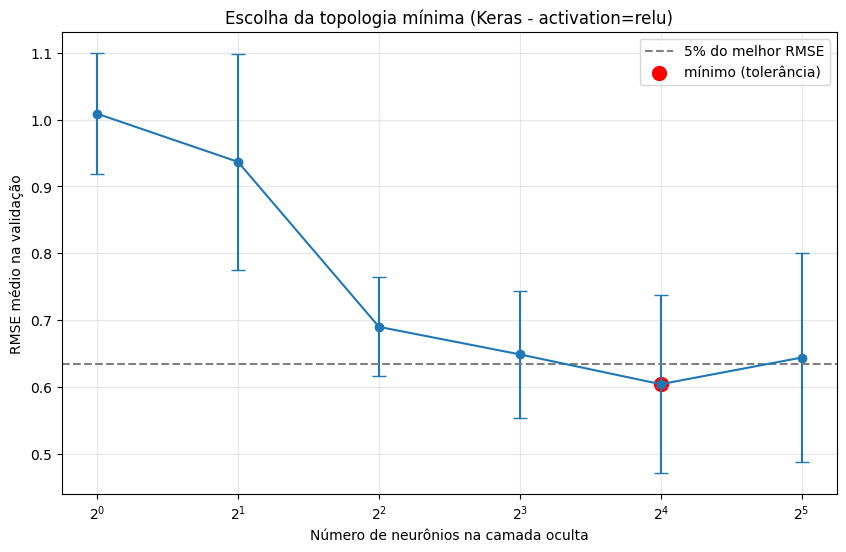

In [9]:
# ==========================
# Plot RMSE médio vs hidden size e destacar escolha
# ==========================

hs_list = [r['hidden'] for r in results_keras]
rmse_means = [r['rmse_mean'] for r in results_keras]
rmse_stds = [r['rmse_std'] for r in results_keras]

plt.figure(figsize=(10, 6))
plt.errorbar(hs_list, rmse_means, yerr=rmse_stds, marker='o', linestyle='-', capsize=5)
plt.axhline(best_rmse * 1.05, color='gray', linestyle='--', label='5% do melhor RMSE')
plt.scatter([min_tol_cfg['hidden']], [min_tol_cfg['rmse_mean']], color='red', s=100, label='mínimo (tolerância)')
plt.xscale('log', base=2)
plt.xlabel('Número de neurônios na camada oculta')
plt.ylabel('RMSE médio na validação')
plt.legend()
plt.title(f'Escolha da topologia mínima (Keras - activation={activation})')
plt.grid(True, alpha=0.3)
plt.show()

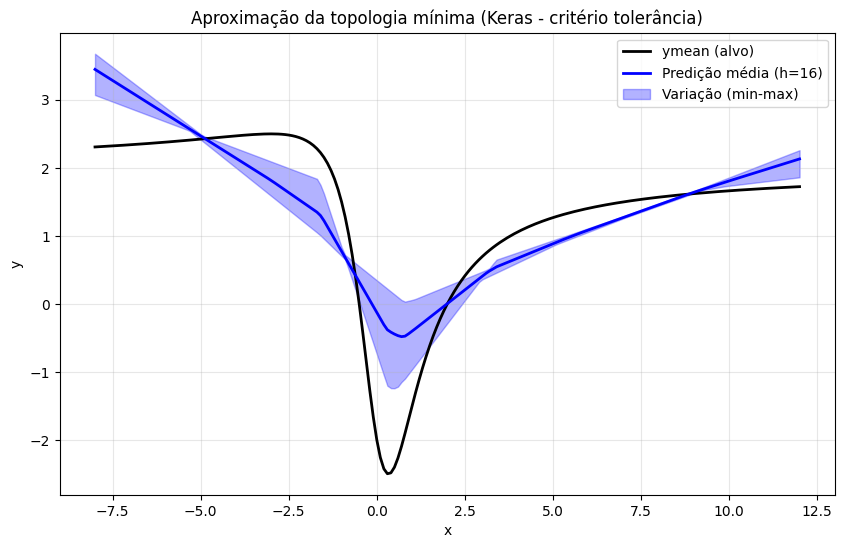

In [10]:
# ==========================
# Visual: ymean vs predições médias da topologia mínima (tolerância)
# ==========================

preds = min_tol_cfg['preds_grid']
mean_pred = preds.mean(axis=0)
min_pred = preds.min(axis=0)
max_pred = preds.max(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(xgrd.ravel(), ymean, label='ymean (alvo)', color='black', linewidth=2)
plt.plot(xgrd.ravel(), mean_pred, label=f'Predição média (h={min_tol_cfg["hidden"]})', color='blue', linewidth=2)
plt.fill_between(xgrd.ravel(), min_pred, max_pred, alpha=0.3, color='blue', label='Variação (min-max)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Aproximação da topologia mínima (Keras - critério tolerância)')
plt.grid(True, alpha=0.3)
plt.show()

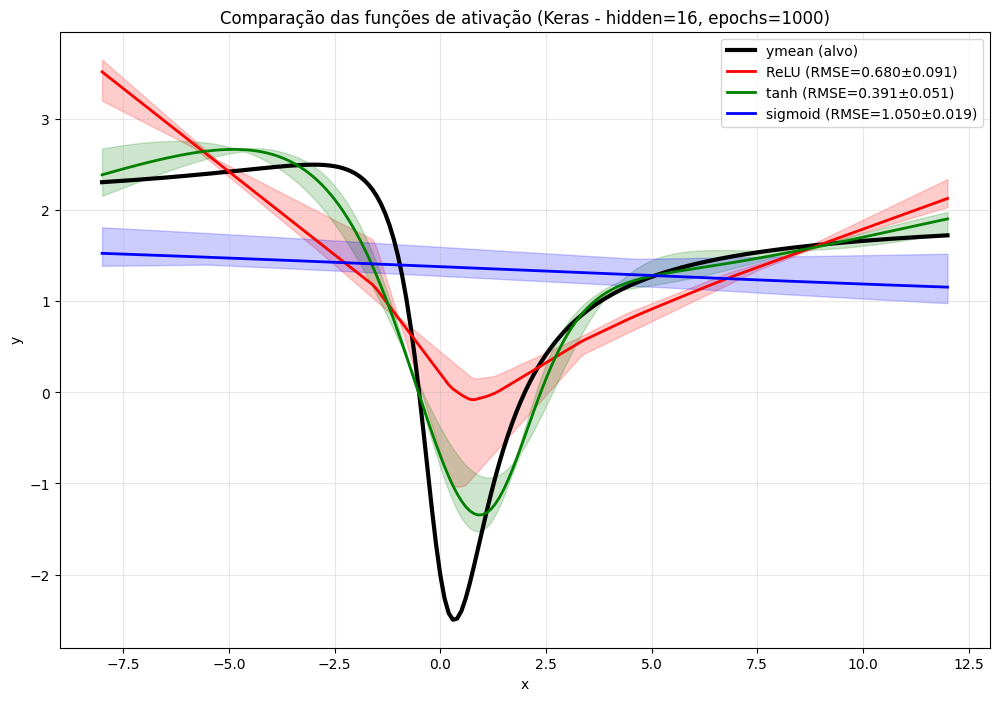

In [11]:
# ============================================================
# (2) TESTAR DIFERENTES FUNÇÕES DE ATIVAÇÃO NA CAMADA ESCONDIDA
# ============================================================

activations = {
    'ReLU': 'relu',
    'tanh': 'tanh',
    'sigmoid': 'sigmoid'
}

hidden_size = 16
epochs = 1000
n_repeats = 5

results_act_keras = []

for name, act in activations.items():
    preds_grid = []
    rmses = []

    for rep in range(n_repeats):
        tf.random.set_seed(42 + rep)
        np.random.seed(42 + rep)

        model = create_mlp_model(hidden_size, activation=act)

        history = model.fit(
            Xs_train, ys_train,
            epochs=epochs,
            batch_size=32,
            validation_data=(Xs_val, ys_val),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
        )

        # Avaliar RMSE em validação
        pred_val_s = model.predict(Xs_val, verbose=0).flatten()
        pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_val, pred_val))
        rmses.append(rmse)

        # Predição na grade xgrd
        pred_grid_s = model.predict(xgrd_s, verbose=0).flatten()
        pred_grid = sc_y.inverse_transform(pred_grid_s.reshape(-1,1)).ravel()
        preds_grid.append(pred_grid)

    results_act_keras.append({
        'activation': name,
        'rmse_mean': np.mean(rmses),
        'rmse_std': np.std(rmses),
        'preds': np.array(preds_grid)
    })

# Plotar comparações
plt.figure(figsize=(12, 8))
plt.plot(xgrd.ravel(), ymean, color='black', label='ymean (alvo)', linewidth=3)

colors = ['red', 'green', 'blue']
for i, r in enumerate(results_act_keras):
    mean_pred = r['preds'].mean(axis=0)
    plt.plot(xgrd.ravel(), mean_pred,
             label=f"{r['activation']} (RMSE={r['rmse_mean']:.3f}±{r['rmse_std']:.3f})",
             color=colors[i], linewidth=2)
    plt.fill_between(xgrd.ravel(),
                    r['preds'].min(axis=0),
                    r['preds'].max(axis=0),
                    alpha=0.2, color=colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Comparação das funções de ativação (Keras - hidden={hidden_size}, epochs={epochs})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== RESULTADOS COMPLETOS (Keras) ===
Ativação: ReLU     | Neurônios:  1 | Epochs:  200 | RMSE: 0.9444 ± 0.0845
Ativação: ReLU     | Neurônios:  1 | Epochs: 1000 | RMSE: 1.0366 ± 0.0604
Ativação: ReLU     | Neurônios:  2 | Epochs:  200 | RMSE: 0.8143 ± 0.0558
Ativação: ReLU     | Neurônios:  2 | Epochs: 1000 | RMSE: 0.8344 ± 0.1371
Ativação: ReLU     | Neurônios:  4 | Epochs:  200 | RMSE: 0.8034 ± 0.0558
Ativação: ReLU     | Neurônios:  4 | Epochs: 1000 | RMSE: 0.7063 ± 0.0421
Ativação: ReLU     | Neurônios:  8 | Epochs:  200 | RMSE: 0.7272 ± 0.0151
Ativação: ReLU     | Neurônios:  8 | Epochs: 1000 | RMSE: 0.6516 ± 0.0954
Ativação: ReLU     | Neurônios: 16 | Epochs:  200 | RMSE: 0.6888 ± 0.0298
Ativação: ReLU     | Neurônios: 16 | Epochs: 1000 | RMSE: 0.5469 ± 0.1424
Ativação: ReLU     | Neurônios: 32 | Epochs:  200 | RMSE: 0.6501 ± 0.0721
Ativação: ReLU     | Neurônios: 32 | Epochs: 1000 | RMSE: 0.5891 ± 0.1677
Ativação: tanh     | Neurônios:  1 | Epochs:  200 | RMSE: 1.0409 ± 0.0320


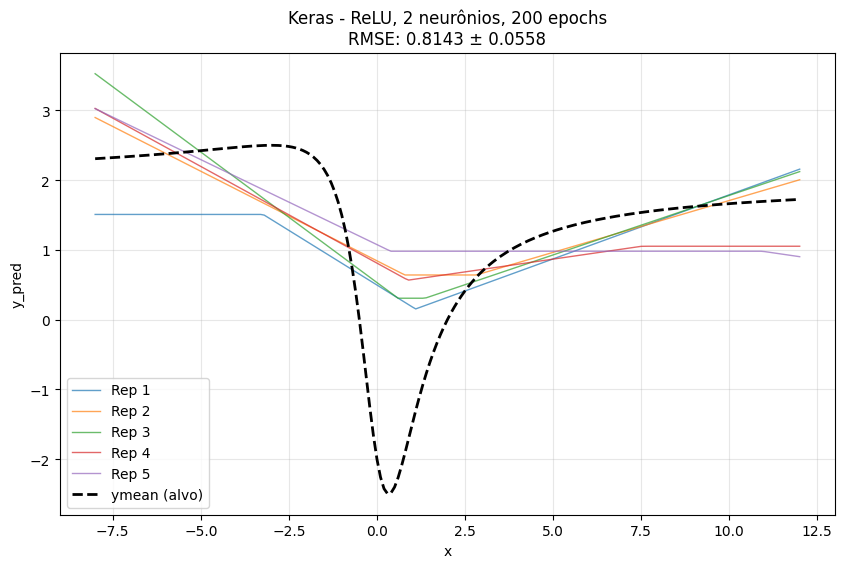

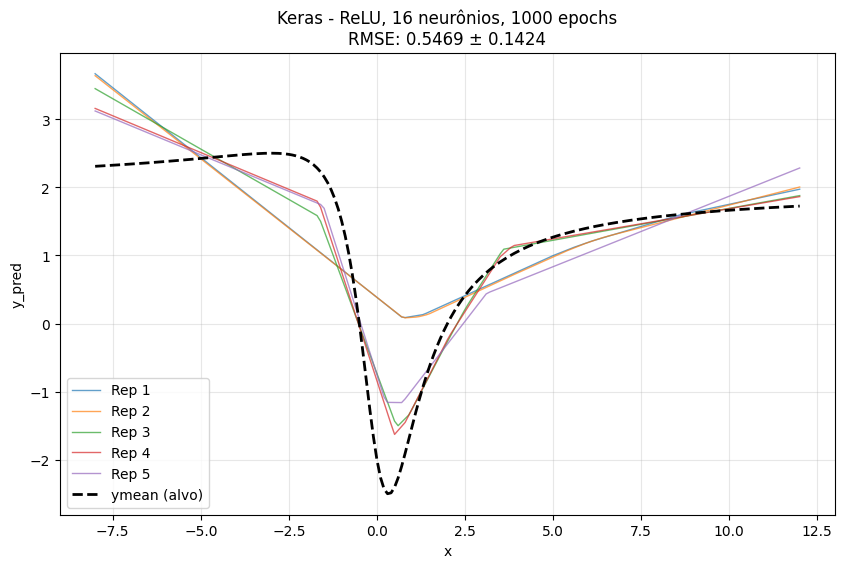

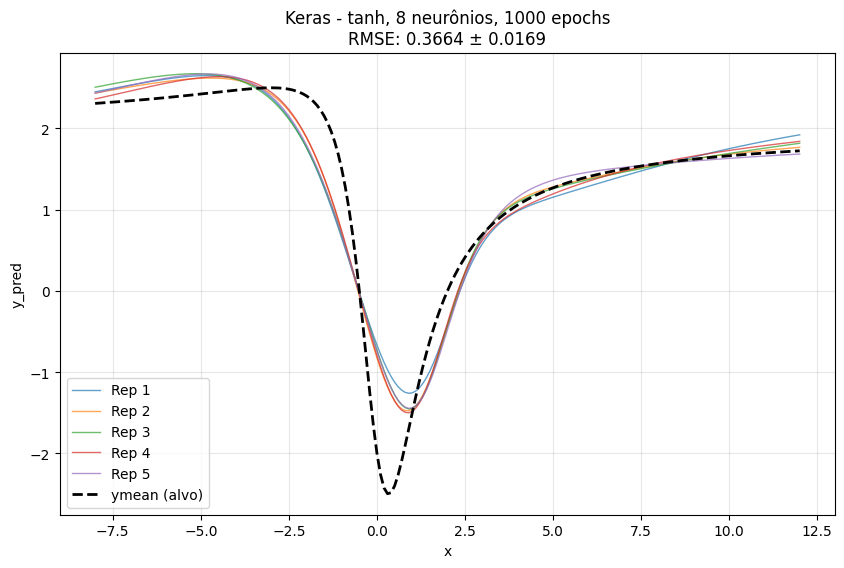

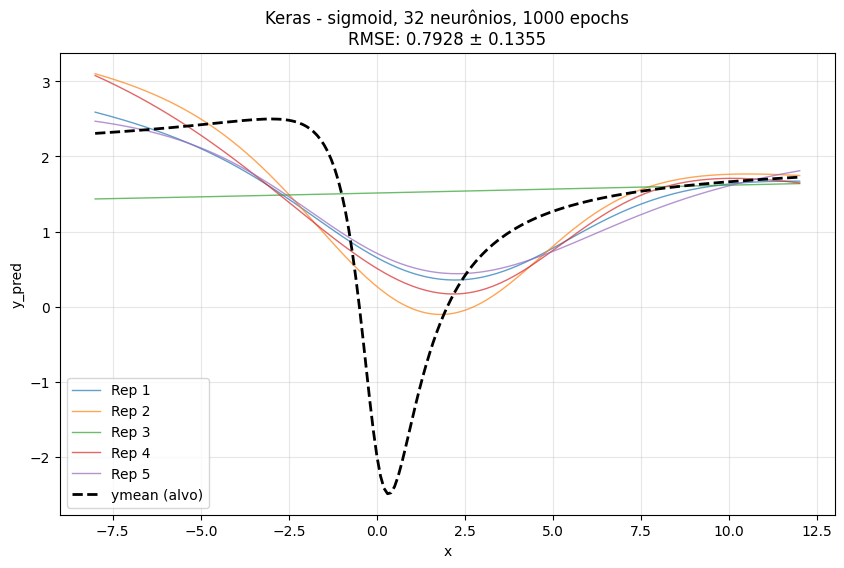

In [12]:
# =====================================================================================
# (3) TESTAR 5 REPETIÇÕES POR CONFIGURAÇÃO COM DIFERENTES EPOCHS E ANALISAR VARIABILIDADE
# =====================================================================================

epochs_list = [200, 1000]
n_repeats = 5
results_keras_full = []
hidden_sizes_list = hidden_candidates

for act_name, act_val in activations.items():
    for hs in hidden_sizes_list:
        for epochs in epochs_list:
            preds_on_grid = []
            rmses_val = []
            histories = []

            for rep in range(n_repeats):
                tf.random.set_seed(42 + rep)
                np.random.seed(42 + rep)

                model = create_mlp_model(hs, activation=act_val)

                history = model.fit(
                    Xs_train, ys_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(Xs_val, ys_val),
                    verbose=0,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
                )

                histories.append(history.history)

                # Avaliação no conjunto de validação
                pred_val_s = model.predict(Xs_val, verbose=0).flatten()
                pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
                rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
                rmses_val.append(rmse_val)

                # Predição na malha xgrd
                pred_s = model.predict(xgrd_s, verbose=0).flatten()
                pred = sc_y.inverse_transform(pred_s.reshape(-1,1)).ravel()
                preds_on_grid.append(pred)

            results_keras_full.append({
                'activation': act_name,
                'hidden': hs,
                'epochs': epochs,
                'preds_grid': np.array(preds_on_grid),
                'rmse_val_mean': np.mean(rmses_val),
                'rmse_val_std': np.std(rmses_val),
                'histories': histories
            })

# Exibir resultados
print("\n=== RESULTADOS COMPLETOS (Keras) ===")
for res in results_keras_full:
    print(f"Ativação: {res['activation']:8} | Neurônios: {res['hidden']:2} | Epochs: {res['epochs']:4} | RMSE: {res['rmse_val_mean']:.4f} ± {res['rmse_val_std']:.4f}")

# Plotar predições para algumas configurações representativas
configs_to_plot = [
    ('ReLU', 2, 200), ('ReLU', 16, 1000),
    ('tanh', 8, 1000), ('sigmoid', 32, 1000)
]

for act, hs, ep in configs_to_plot:
    res = next(r for r in results_keras_full if r['activation']==act and r['hidden']==hs and r['epochs']==ep)

    plt.figure(figsize=(10, 6))
    for i in range(n_repeats):
        plt.plot(xgrd, res['preds_grid'][i], label=f'Rep {i+1}', alpha=0.7, linewidth=1)

    plt.plot(xgrd.ravel(), ymean, 'k--', label='ymean (alvo)', linewidth=2)
    plt.title(f"Keras - {act}, {hs} neurônios, {ep} epochs\nRMSE: {res['rmse_val_mean']:.4f} ± {res['rmse_val_std']:.4f}")
    plt.xlabel('x')
    plt.ylabel('y_pred')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
# ================================================================
# (4) RELATÓRIO CURTO (PDF) COM RESULTADOS E DISCUSSÃO DOS ITENS 1-3
# ================================================================

# Identificar a melhor configuração
best_cfg_keras = min(results_keras_full, key=lambda r: r['rmse_val_mean'])

with PdfPages("relatorio_final_keras.pdf") as pdf:
    # Capa
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    plt.text(0.5, 0.75, "Relatório Final - Experimentos MLP com Keras", ha='center', va='center', fontsize=18)
    plt.text(0.5, 0.65, "Desafio 01 - Redes Neurais Artificiais \nAluna: Cristiane Gea", ha='center', fontsize=14)
    plt.text(0.5, 0.5,
             "Itens avaliados:\n"
             "(1) Topologia mínima com Keras\n"
             "(2) Funções de ativação (ReLU, tanh, sigmoid)\n"
             "(3) Avaliação de 5 repetições por configuração\n"
             "(4) Relatório curto com discussão\n",
             ha='center', va='center', fontsize=10)
    pdf.savefig(); plt.close()

    # Páginas por ativação
    for act in activations.keys():
        cfgs = [r for r in results_keras_full if r['activation']==act]
        fig, axes = plt.subplots(6, 2, figsize=(8.27, 11.69))
        fig.suptitle(f"Keras - Ativação: {act}", fontsize=14)
        axes = axes.flatten()

        for i, cfg in enumerate(sorted(cfgs, key=lambda x:(x['hidden'], x['epochs']))):
            ax = axes[i]
            preds = cfg['preds_grid']
            mean_pred = preds.mean(axis=0)

            ax.plot(xgrd.ravel(), ymean, label='ymean (alvo)', color='black', linewidth=1.5)
            ax.plot(xgrd.ravel(), mean_pred, label=f'pred média', color='blue', linewidth=1)
            ax.fill_between(xgrd.ravel(), preds.min(axis=0), preds.max(axis=0), color='blue', alpha=0.2)

            title = f"h={cfg['hidden']}, ep={cfg['epochs']}\nRMSE={cfg['rmse_val_mean']:.3f}±{cfg['rmse_val_std']:.3f}"
            if cfg is best_cfg_keras:
                title = "⭐ " + title
            ax.set_title(title, fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=6)

        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf.savefig(fig); plt.close(fig)

    # Página de discussão
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    text = (
        f"RELATÓRIO KERAS - RESULTADOS PRINCIPAIS\n\n"
        f"⭐ Melhor configuração: {best_cfg_keras['activation']} com "
        f"{best_cfg_keras['hidden']} neurônios e {best_cfg_keras['epochs']} épocas\n"
        f"RMSE médio de validação: {best_cfg_keras['rmse_val_mean']:.4f} ± {best_cfg_keras['rmse_val_std']:.4f}\n\n"
        "OBSERVAÇÕES:\n"
        "• Implementação equivalente usando Keras/TensorFlow\n"
        "• Early Stopping implementado para evitar overfitting\n"
        "• Otimizador Adam com learning rate padrão de 0.001\n"
        "• Batch size fixo em 32 para todos os experimentos\n"
        "• Mesma metodologia de avaliação do scikit-learn"
    )
    plt.text(0.05, 0.95, text, va='top', fontsize=10, wrap=True, linespacing=1.5)
    pdf.savefig(); plt.close()

print("✅ Relatório Keras salvo como: [Cristiane Gea - Relatório Final] 1º Desafio em RNA Deep Learning sem Keras.pdf")
print("✅ Experimentos concluídos com sucesso!")

✅ Relatório Keras salvo como: relatorio_final_keras.pdf
✅ Experimentos concluídos com sucesso!
